# **Cryosphere - Monitoring Melting Ice**
### **Part1** Permafrost: seasonal freeze-thaw cycles

### Introduction
Apart from a long-term decrease in seismic velocity in response to permafrost thawing, single-station monitoring at Mt. Zugspitze reveals seasonal velocity changes (Lindner et al., 2021). These can be attributed to seasonal freeze-thaw cycles. To extract the velocity cycles, we calculated the travel time changes as a function of lag time and frequency using the wavelet cross-spectrum technique (Mao et al., 2020) and used only those time series that exhibit a strong seasonal variation. Specifically, these are the red-colored areas in panels a-c in the figure below.

<div>
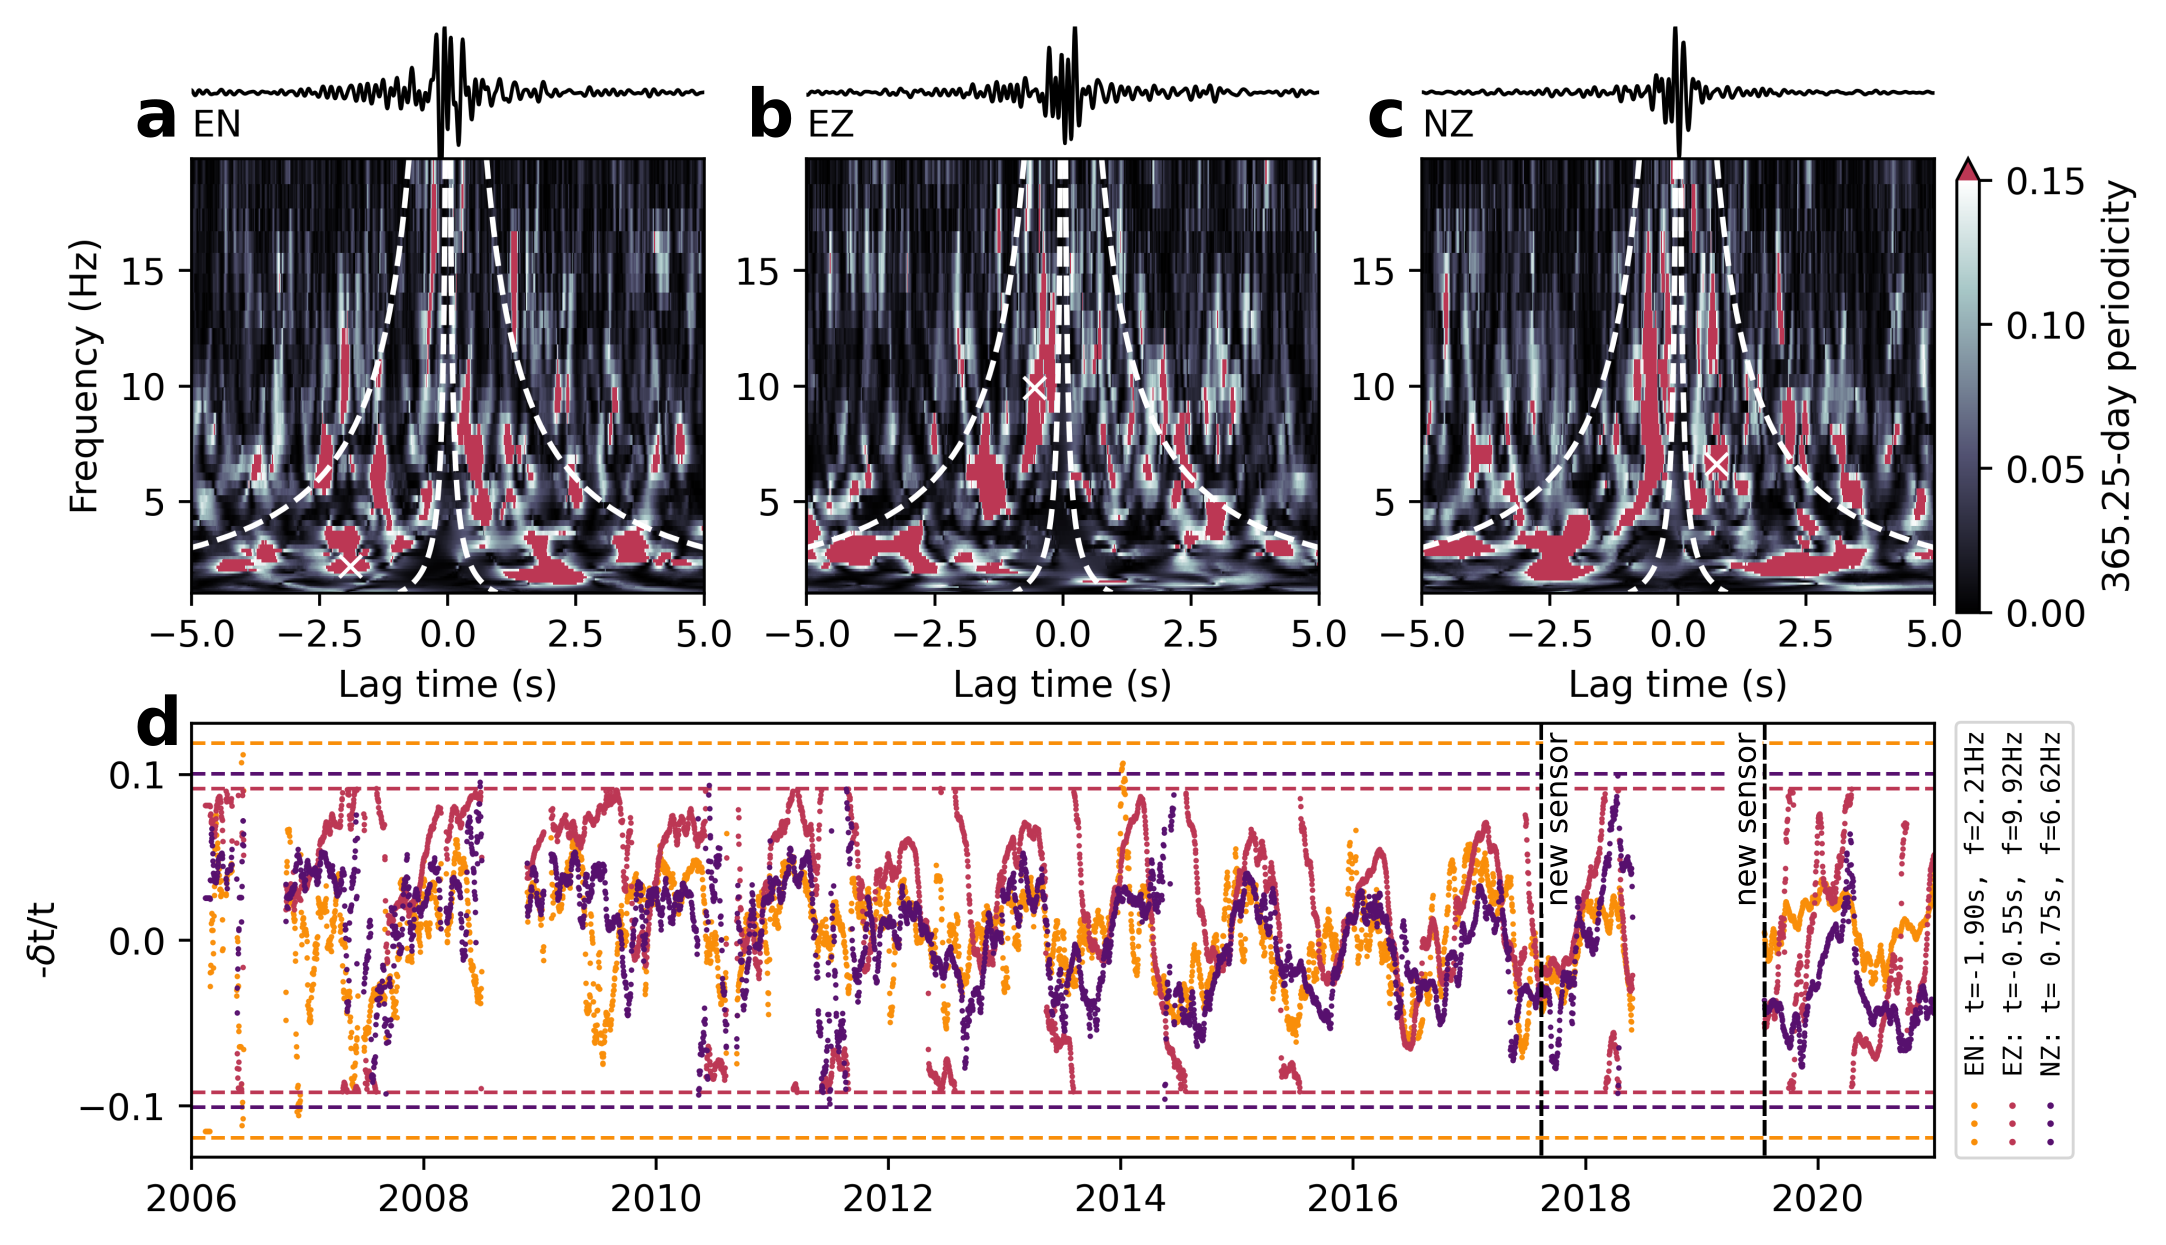
</div>

**Fig. 1**
<em>(a)–(c) EN, EZ, and NZ component cross-correlation reference stacks (seismograms, bandpass filtered 2–8 Hz) and 365.25-day periodicity of travel time shifts relative to the fixed reference (color maps). Red spots indicate combinations of lag time and frequency in the cross-correlations with a significant 1-yr period signal. White dashed lines indicate the frequency dependent lag times of 1 and 15 periods. (d) Travel time shifts (converted to dt/t), for a lag-frequency combination of each component with high 365.25 day periodicity (white crosses in (a)–(c)). The horizontal dashed lines indicate the maximum dt/t measurement ranges for the three curves, outside of which cycle skipping occurs.</em>

### Exercise
As only parts of the coda were used (the red areas that lie between the white dashed lines at positive and negative lag times in the figure above), we want to reprocess the data using continuous coda windows. For this task, we use the wavelet cross-spectrum technique, which allows to investigate also a potential frequency dependence. 

**Play around with the selection of the coda wave window in order to extract robust seasonal velocity changes including a potential frequency dependence.**

To speedup the calculations, you may reduce the number of frequency points ```nptsfreq``` or consider a shorter time window. The parameters that were use to calculate the cross-correlation functions can be found in the supporting information of Lindner et al. (2021). You can find the paper and supporting information here: https://www.geophysik.uni-muenchen.de/~flindner/skience2023/

### References
- Lindner, F., Wassermann, J., & Igel, H. (2021). Seasonal freeze‐thaw cycles and permafrost degradation on Mt. Zugspitze (German/Austrian Alps) revealed by single‐station seismic monitoring. Geophysical Research Letters, 48(18), e2021GL094659.
- Mao, S., Mordret, A., Campillo, M., Fang, H., & van Der Hilst, R. D. (2020). On the measurement of seismic traveltime changes in the time–frequency domain with wavelet cross-spectrum analysis. Geophysical Journal International, 221(1), 550-568.

In [ ]:
#%matplotlib widget
from obspy import read, Stream
from obspy.signal.regression import linear_regression
import glob, os
import numpy as np
import pandas as pd
from datetime import datetime
from wxs_dvv import xwt
import matplotlib.pyplot as plt
import matplotlib

In [ ]:
# Download the data if not already done
if not os.path.exists("STACKS"):
    link2data = "https://www.geophysik.uni-muenchen.de/~flindner/skience2023/part1_data.zip"
    try:
        !conda install -c conda-forge python-wget --yes --quiet
        import wget
        print("Downloading")
        wget.download(link2data)
        !unzip part1_data.zip
    except:
        print(f"please download the data manually from {link2data}\nand unzip "  
             + "the content to the directory of this notebook")

#### Parameters

In [ ]:
# classic MSNoise parameters
filterid = 1
mov_stack = 1     # you may change this, 1, 5 and 15 is possible
sta1 = "BW.ZUGS"
sta2 = "BW.ZUGS"
component = "EN"  # you may change this, "EN", "EZ", "NZ" are available
start = "2019-07-16"
end = "2023-01-12"

# wavelet parameters
freqmin = 1.
freqmax = 20.
nptsfreq = 41
ns = 3
nt = 0.25
vpo = 10

# coda window parameters
coda_win_type = "rectangle"   # you may change this, "rectangle", "LI2021" and "mixed" are possible, see below
dtt_nmin = 4                  # you may change this, min number of periods to use
dtt_nmax = 20                 # you may change this, max number of periods to use
weight_by = "amplitude"       # you may change this, weighting for linear regression, "amplitude" or "coherence"
# the following are also classic MSNoise parameters
dtt_mincoh = 0.65             # you may change this, min coherence to use
dtt_minlag = 1.               # you may change this, min lag time to use
dtt_width = 4.                # you may change this, width of lag window to use
dtt_sides = "both"            # you may change this, "both", "left", or "right"

min_samples = 40              # min number of samples required for linear regression

These are different coda wave windows to use. The width (in lag time) of the windows is controlled by
- ```dtt_nmin``` (min number of periods - for "LI2021" only)
- ```dtt_nmax``` (max number of periods - for "LI2021" and "mixed")
- ```dtt_minlag``` (min lag time to use - for "rectangle" and "mixed")
- ```dtt_width``` (width of the lag window - for "rectangle" only)

<div>
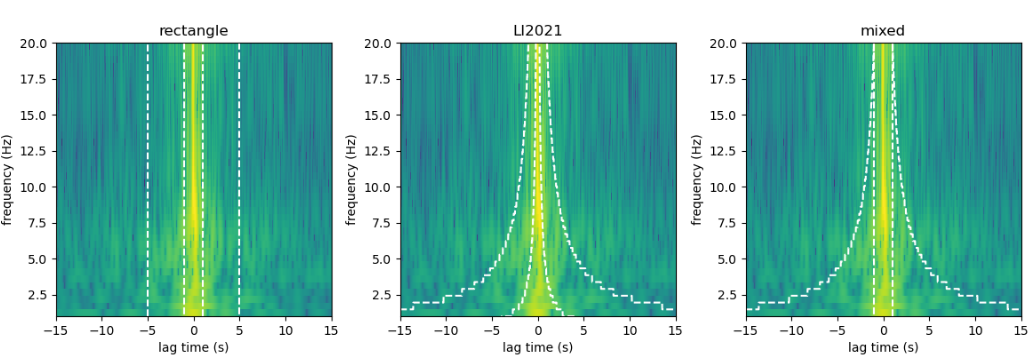
</div>

#### Read the pre-computed cross-correlations

In [ ]:
# first get all time-lapse cross-correlations
traces_cur = []
dates_cur = []
dates_all = pd.date_range(start, end, freq="D")
for date in dates_all:
    fn_cur = f'STACKS/{filterid:02}/{mov_stack:03}_DAYS/{component}/{sta1.replace(".","_")}_{sta2.replace(".", "_")}/{date.date()}.MSEED'
    if os.path.exists(fn_cur):
        dates_cur.append(date.date())
        traces_cur.append(read(fn_cur)[0])

# now get the reference stack
fn_ref = f'STACKS/{filterid:02}/REF/{component}/{sta1.replace(".","_")}_{sta2.replace(".", "_")}.MSEED'
tr_ref = read(fn_ref)[0]
# time axis 
tlag = tr_ref.times() - tr_ref.times().mean() 

#### Plot the time-lapse cross-correlations

In [ ]:
fpmin = 2.   # min freq for plotting
fpmax = 12.  # max freq for plotting

stp = Stream(traces=traces_cur).copy()
stp.filter("bandpass", freqmin=fpmin, freqmax=fpmax, zerophase=True)
datap = np.stack([tr.data for tr in stp]).T

fig = plt.figure(figsize=(10,5))
plt.pcolormesh(dates_cur, tlag, datap, cmap="bone", vmin=-datap.max()*0.2, vmax=datap.max()*0.2)
plt.ylabel("lag time (s)")
plt.ylim(-7.5,7.5)
plt.title(f'{sta1.replace("_", ".")} : {sta2.replace("_", ".")}, {component}, '\
        + f'Filter {filterid:02} ({fpmin:.2f} - {fpmax:.2f} Hz), Stack {mov_stack}',
          fontsize=10)
plt.show()

### Prepare for wavelet cross-spectrum analysis as a function of time
This mainly concerns calculating the indices of the specified coda window

In [ ]:
# get the frequency vector with which we will work
WXamp, _, _, Wcoh, _, freq, _ = xwt(tr_ref.data, tr_ref.data,
                                 tr_ref.stats.sampling_rate,
                                 ns, nt, vpo, freqmin, freqmax, nptsfreq)

# create the mask for the coda window selection
mask = np.zeros((freq.size, tlag.size))
for idxf in range(freq.size):
    
    period = 1. / freq[idxf]
    
    if coda_win_type == "LI2021":
        idx_left = np.where((tlag >= -dtt_nmax*period) & (tlag <= -dtt_nmin*period))[0]
        idx_right = np.where((tlag >= dtt_nmin*period) & (tlag <= dtt_nmax*period))[0]
    
    elif coda_win_type == "mixed":
        idx_left = np.where((tlag >= -dtt_nmax*period) & (tlag <= -dtt_minlag))[0]
        idx_right = np.where((tlag >= dtt_minlag) & (tlag <= dtt_nmax*period))[0]
    
    elif coda_win_type == "rectangle":
        idx_left = np.where((tlag >= -dtt_minlag-dtt_width) & (tlag <= -dtt_minlag))[0]
        idx_right = np.where((tlag >= dtt_minlag) & (tlag <= dtt_minlag + dtt_width))[0]
    
    else:
        raise ValueError("'%s' not known - choose 'LI2021', 'rectangle' or 'mixed' for parameter coda_win_type" % coda_win_type)
    
    
    if dtt_sides == "both":
        idxl = np.concatenate((idx_left,idx_right))
    elif dtt_sides == "left":
        idxl = idx_left
    elif dtt_sides == "right":
        idxl = idx_right
    else:
        raise ValueError("'%s' not known - choose 'both', 'left' or 'right' for parameter dtt_sides" % dtt_sides)

    mask[idxf,idxl] = 1
    

# Show selected window
WXamp_masked = np.ma.masked_where(mask==0, WXamp)
fig = plt.figure(figsize=(5,4))
im = plt.pcolormesh(tlag, freq, np.log10(WXamp/WXamp.max()), cmap="viridis")
cb = plt.colorbar(im)
cb.set_label("log10(amplitude), normalized")
plt.contour(tlag, freq, mask, cmap="binary", linewidths=1.5, levels=[1], linestyles="--")
plt.ylabel("frequency (Hz)")
plt.xlabel("lag time (s)")
plt.title("coda window selection: %s" % coda_win_type, fontsize=10)
plt.show()

### Calculate dv/v using the wavelet cross-spectrum technique

In [ ]:
# initialize dv/v
dvv = np.zeros((freq.size,len(traces_cur)))
dvv_err = np.zeros(dvv.shape)

# loop over daily cross-correlations ...
print("calculating dv/v for ...")
for idxt, tr_cur in enumerate(traces_cur):
    
    if dates_cur[idxt].day == 1 and dates_cur[idxt].month % 2 != 0:
        print(dates_cur[idxt])

    # ... do wavelet cross-spectrum against reference cross-correlation ...
    WXamp, _, _, Wcoh, WXdt, freq, _ = xwt(tr_ref.data, tr_cur.data,
                                           tr_ref.stats.sampling_rate,
                                           ns, nt, vpo, freqmin, freqmax, nptsfreq)
    Wcoh *= mask
    WXamp *= mask
    if weight_by == "coherence":
        weights = Wcoh
    elif weight_by == "amplitude":
        weights = np.log(np.abs(WXamp)) / np.log(np.abs(WXamp)).max()
    else:
        raise ValueError("'%s' not known - choose 'coherence' or 'amplitude' for parameter weight_by" % weight_by)
                    
    # ... do linear regression for each frequency considering inside the lag window that have exceed dtt_mincoh
    for idxf in range(freq.size):
        idxl = np.where(Wcoh[idxf,:] >= dtt_mincoh + 1e-5)[0]  # prevent selecting lag times if dtt_mincoh is set to 0
        # only do dv/v calculation if at least a specified number of samples are available
        if idxl.size >= min_samples:            
            dtt = linear_regression(tlag[idxl], WXdt[idxf,idxl], weights=weights[idxf,idxl], intercept_origin=True)
            dvv[idxf,idxt] = -dtt[0]
            dvv_err[idxf,idxt] = dtt[1]
        else:
            dvv[idxf,idxt] = np.nan
            dvv_err[idxf,idxt] = np.nan
print("======== done! =========")

In [ ]:
# some values for plotting
# frequency range over which is averaged
f1 = 2
f2 = 8
idx = np.where((freq >= 1) & (freq <= f2))[0]
# dv/v range to show
dvv_min = -0.03
dvv_max = 0.03

# and now the figure
fig = plt.figure(figsize=(10,8))

# axis 1 - dv/v as a function of time and frequency
ax1 = fig.add_axes([0.08,0.68,0.8,0.25])
ax1.set_title(f'dv/v {sta1.replace("_", ".")} : {sta2.replace("_", ".")}, {component}, '\
            + f'Filter {filterid:02}, Stack {mov_stack}', fontsize=10)
cax1 = fig.add_axes([0.9,0.68,0.015,0.25])
im1 = ax1.pcolormesh(dates_cur, freq, dvv, cmap="seismic_r", vmin=dvv_min, vmax=dvv_max)
cb1 = plt.colorbar(im1, cax=cax1)
cb1.set_label("dv/v")
ax1.axhline(f1, color="k", linestyle="--", lw=1)
ax1.axhline(f2, color="k", linestyle="--", lw=1)
ax1.set_ylabel("frequency (Hz)")

# axis 2 - dv/v as a function of time and frequency, line plot
cmap = matplotlib.cm.seismic
cols = matplotlib.cm.get_cmap(cmap.name, freq.size)
ax2 = fig.add_axes([0.08,0.38,0.8,0.26])
cax2 = fig.add_axes([0.9,0.38,0.015,0.26])
for i in range(freq.size):
    ax2.plot(dates_cur, dvv[i,:], c=cols(freq.size-i), lw=0.5, alpha=0.5)
cnorm = matplotlib.colors.Normalize(vmin=freq.min(), vmax=freq.max())
im2 = matplotlib.cm.ScalarMappable(cmap=cmap, norm=cnorm)
cb2 = plt.colorbar(im2, cax=cax2)
cb2.set_label("frequency (Hz)")
ax2.set_ylabel("dv/v")
ax2.set_ylim(dvv_min, dvv_max)

# axis 3 - comparison with dv/v from Lindner et al. (2021) and temperature data
dvv_LI2021 = pd.read_csv(f'BW_ZUGS_BW_ZUGS-{component}-m15-f1.csv', parse_dates=["Date"])
ax3 = fig.add_axes([0.08,0.08,0.8,0.26])
ax3.plot(dvv_LI2021["Date"], dvv_LI2021["dvv"]-np.nanmean(dvv_LI2021["dvv"]), "gray", label="LI2021 (2.0 - 8.0 Hz)")
ax3.plot(dates_cur, np.average(dvv[idx,:], axis=0), label="reprocessed (%.1f - %.1f Hz)" % (f1, f2))
ax3.set_ylabel("dv/v")
ax3.set_ylim(dvv_min, dvv_max)
plt.legend(loc=2, fontsize=9)

ax3t = ax3.twinx()
ax3t.plot(pd.read_csv("temp_1m_depth.csv", parse_dates=["Datum"]).set_index("Datum"), color="C3", lw=3, alpha=0.7)
ax3t.set_zorder(ax3.get_zorder()-1)
ax3.set_frame_on(False)
ax3t.invert_yaxis()
ax3t.set_ylabel("rock temperature @ 1m depth (°C)", color="C3")
ax3t.tick_params(axis="y", colors="C3")
ax3t.spines["right"].set_color("C3")

# set date ranges
for ax in [ax1,ax2,ax3]:
    ax.set_xlim(dates_cur[0], dates_cur[-1])
plt.show()